In [1]:
from neo4j import GraphDatabase
import pandas as pd
from matplotlib import pyplot as plt
from neo4_connection import USER, PWD, URL

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [2]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
query = """
match (m:Movie) -[:IN_GENRE]-> (g:Genre)
with m.movieId as movieId, collect(g.name) as genres, m.genreEmbedding as embedding

return movieId, genres, 'Animation' in genres as isAnimation, embedding
"""

df = fetch_data(query)
df.head()

,movieId,genres,isAnimation,embedding
0,114552,"[Adventure, Animation, Children, Comedy, Fantasy]",True,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,115664,"[Adventure, Animation, Romance]",True,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,113348,"[Adventure, Comedy, Action]",False,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,113345,"[Adventure, Action, Sci-Fi]",False,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,112460,"[Adventure, Animation, Comedy]",True,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movieId      9125 non-null   int64 
 1   genres       9125 non-null   object
 2   isAnimation  9125 non-null   bool  
 3   embedding    9125 non-null   object
dtypes: bool(1), int64(1), object(2)
memory usage: 222.9+ KB


In [5]:
X = np.array(df['embedding'].values.tolist())
X.shape, X[0]

((9125, 20),
 array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [6]:
tsne = TSNE(n_components=2, perplexity=19, init='random', learning_rate='auto')
embed_reduced = tsne.fit_transform(X)

In [7]:
df['pca-one'] = embed_reduced[:,0]
df['pca-two'] = embed_reduced[:,1]
df.head()

,movieId,genres,isAnimation,embedding,pca-one,pca-two
0,114552,"[Adventure, Animation, Children, Comedy, Fantasy]",True,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",-4.898357,56.236153
1,115664,"[Adventure, Animation, Romance]",True,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-25.114735,46.315025
2,113348,"[Adventure, Comedy, Action]",False,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-10.815870,30.901661
3,113345,"[Adventure, Action, Sci-Fi]",False,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.142460,23.758070
4,112460,"[Adventure, Animation, Comedy]",True,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.496916,50.753128


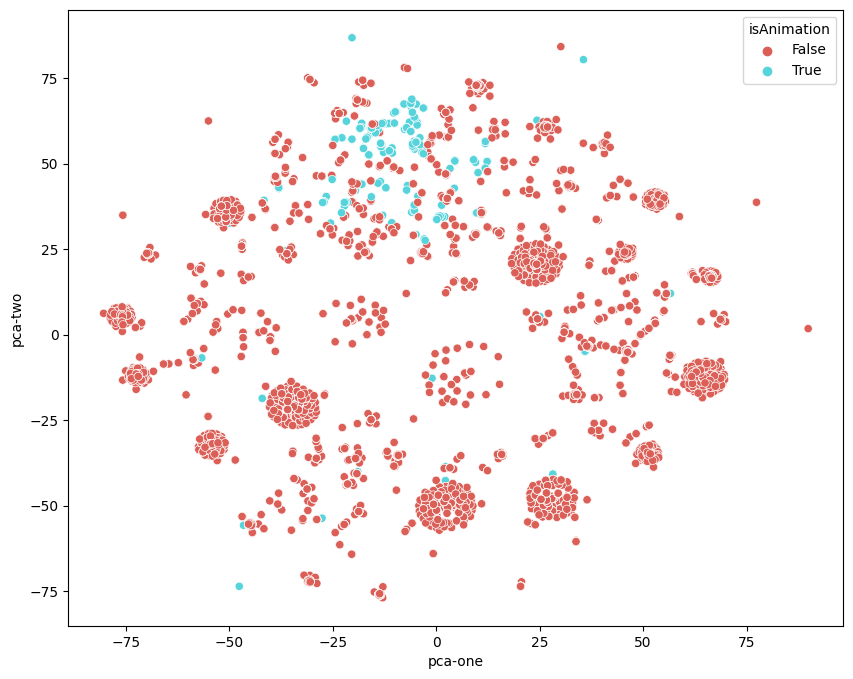

In [8]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="isAnimation",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    #alpha=0.3
)
plt.show()

In [9]:
query = """
match (u:User) -[r:RATED]-> (m:Movie)
where r.rating <= 4.0
// and u.userId = "1"
with u.userId as userId, collect(m.title) as movies, collect(m.genreEmbedding) as embeddings
return userId, size(embeddings) as embed_size, embeddings
"""

df = fetch_data(query)
# df

In [10]:
df.shape

(671, 3)

In [11]:
mean_embeds = []
mean_norm_embeds = []
for i, row in df.iterrows():
    embed_array = pd.DataFrame(df.loc[i, 'embeddings']).values
    mean_embed = np.mean(embed_array, axis=0)
    mean_norm_embed = mean_embed / np.sum(mean_embed)
    #print(mean_embed.shape, mean_embed, mean_norm_embed, np.sum(mean_norm_embed))
    mean_embeds.append(mean_embed), mean_norm_embeds.append(mean_norm_embed)

mean_embeds, mean_norm_embeds = pd.Series(mean_embeds), pd.Series(mean_norm_embeds)
df['mean_embed'], df['mean_norm_embeds'] = mean_embeds, mean_norm_embeds

df.head()

,userId,embed_size,embeddings,mean_embed,mean_norm_embeds
0,1,20,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.25, 0.45, 0.15, 0.1, 0.25, 0.1, 0.0, 0...","[0.0, 0.09259259259259262, 0.1666666666666667,..."
1,2,65,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.26153846153846155, 0.15384615384615385...","[0.0, 0.09714285714285717, 0.05714285714285716..."
2,3,42,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...","[0.0, 0.3333333333333333, 0.21428571428571427,...","[0.0, 0.11965811965811966, 0.07692307692307693..."
3,4,85,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[0.0, 0.3411764705882353, 0.35294117647058826,...","[0.0, 0.12083333333333335, 0.12500000000000003..."
4,5,76,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.13157894736842105, 0.23684210526315788...","[0.0, 0.04784688995215311, 0.08612440191387559..."


In [12]:
X = np.array(df['mean_norm_embeds'].values.tolist())
# X.shape, X

In [13]:
argmax_X = np.argmax(X, axis=1)
argmin_X = np.argmin(X, axis=1)
argmax_X.shape

(671,)

In [14]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto')
embed_reduced = tsne.fit_transform(X)

In [15]:
df['pca-one'] = embed_reduced[:,0]
df['pca-two'] = embed_reduced[:,1]
df['argmax'] = argmax_X
df['argmin'] = argmin_X
df.head()

,userId,embed_size,embeddings,mean_embed,mean_norm_embeds,pca-one,pca-two,argmax,argmin
0,1,20,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.25, 0.45, 0.15, 0.1, 0.25, 0.1, 0.0, 0...","[0.0, 0.09259259259259262, 0.1666666666666667,...",1.829119,18.469353,2,0
1,2,65,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.26153846153846155, 0.15384615384615385...","[0.0, 0.09714285714285717, 0.05714285714285716...",1.643376,-11.169213,8,0
2,3,42,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...","[0.0, 0.3333333333333333, 0.21428571428571427,...","[0.0, 0.11965811965811966, 0.07692307692307693...",-0.269612,4.976958,8,0
3,4,85,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[0.0, 0.3411764705882353, 0.35294117647058826,...","[0.0, 0.12083333333333335, 0.12500000000000003...",3.585966,11.583852,5,0
4,5,76,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.13157894736842105, 0.23684210526315788...","[0.0, 0.04784688995215311, 0.08612440191387559...",16.931120,-2.679075,5,0


C:\Users\roman\AppData\Local\Temp\ipykernel_14840\1503024287.py:10: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.scatterplot(


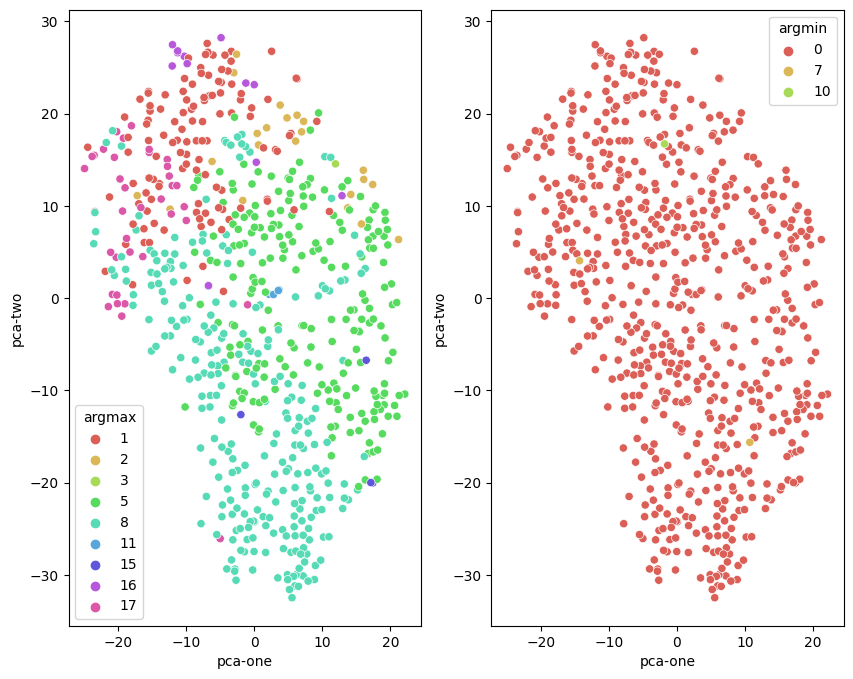

In [16]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="argmax",
    palette=sns.color_palette("hls", 9),
    data=df,
    legend="full",
    ax=ax0
)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="argmin",
    palette=sns.color_palette("hls", 9),
    data=df,
    legend="full",
    ax=ax1
)

plt.show()